In [117]:
import subprocess, psutil, time, json, pandas, math, numpy, threading
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter

class ScalarFormatterClass(ScalarFormatter):
   def _set_format(self):
      self.format = "%1.2f"


[0.818, 2.802, 8.268, 8.318, 28.979, 92.004, 105.958, 107.594]
<class 'numpy.ndarray'>


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


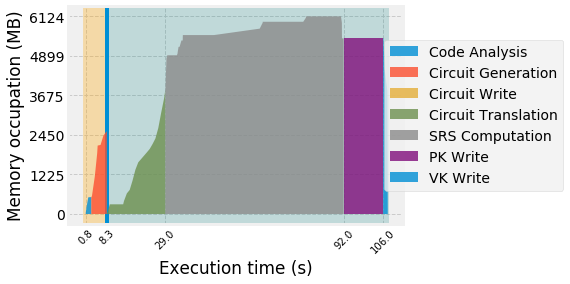

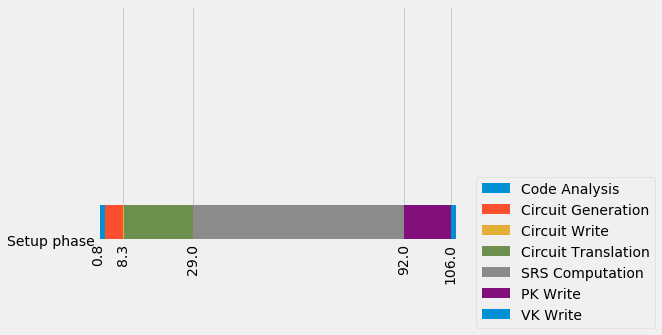

In [2]:
###SETUP PLOT###
circuit = 'HTTP_String'
pastel_cmap = cm.get_cmap('Pastel1')
df2 = pandas.read_json("../Middlebox/setup_"+circuit+"_output.json").round(3)
df2.columns = ['output', 'timestamp']
#print(df.to_string())
timestamps=df2['timestamp']
df2 = df2.iloc[:, [1,0]]
df2.set_index('timestamp')

df = pandas.read_json("../Middlebox/setup_"+circuit+"_memory.json").round(3)
df.columns = ['memory', 'timestamp']
df = df.iloc[:, [1,0]]
df.set_index('timestamp')
#df2['timestamp'].add(last_time)
#df=df.append(df2,ignore_index=True)
#print(df.to_string())
#print(df.to_string())
#print(df2.to_string())
timestamps=df2['timestamp']

highlights = [timestamps[0], timestamps[96], timestamps[102], timestamps[108], timestamps[118], timestamps[191], timestamps[192], timestamps[199]]
print(highlights)
labels = ["Code Analysis", "Circuit Generation", "Circuit Write", "Circuit Translation", "SRS Computation", "PK Write", "VK Write"]
df.set_index('timestamp')
df2.set_index('timestamp')
df = df.merge(df2, how = 'outer')
df['memory'] = df['memory'].fillna(value=0)
#print(df.to_string())


plt.figure()

#print(plt.style.available)
plt.style.use('fivethirtyeight')
plt.plot(df['timestamp'], df['memory'], linewidth=0, zorder=3)

#print(df['timestamp'] in highlights)
#print(df[df['timestamp'] in highlights].to_string())

ticks=[]
for tick in highlights:
	if not ticks or ticks[-1]<tick-2:
		ticks.append(tick)
plt.xlabel("Execution time (s)")
plt.ylabel("Memory occupation (MB)")
print(type(numpy.arange(0, max(df['memory']), step=max(df['memory'])/5)))
plt.yticks(numpy.append(numpy.arange(0, max(df['memory']), step=max(df['memory'])/5), max(df['memory'])))
#plt.xticks(numpy.arange(0, max(df['timestamp']), step=max(df['timestamp'])/5))
plt.xticks(ticks, rotation = 45, fontsize=10)

for (i,instant) in enumerate(highlights[:-1]):
	index = df['timestamp'].between(highlights[i], highlights[i+1], inclusive="both")
	plt.fill_between(df['timestamp'][index], df['memory'][index], label=labels[i], alpha=0.8, zorder=4+i)
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5)).set_zorder(100)
plt.grid(linestyle = '--', linewidth = 1, zorder=2)
plt.axvspan(0, highlights[3], color='orange', alpha=0.3, zorder=1)
plt.axvspan(highlights[3], highlights[-1], color='teal', alpha=0.2, zorder=1)
plt.axvline(highlights[3])

plt.show()

for (i, instant) in enumerate(highlights[:-1]):
    plt.barh("Setup phase", highlights[i+1]-highlights[i], height=0.3, left = (highlights[i]), label=labels[i])
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 0.3))
plt.xticks(ticks, rotation=90)
plt.ylim(0,1)
plt.show()
 


##END SETUP###


<class 'numpy.ndarray'>


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


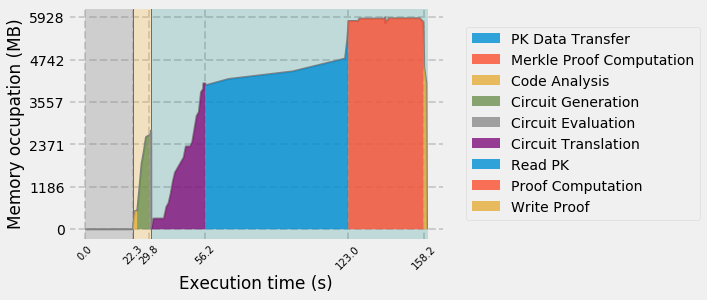

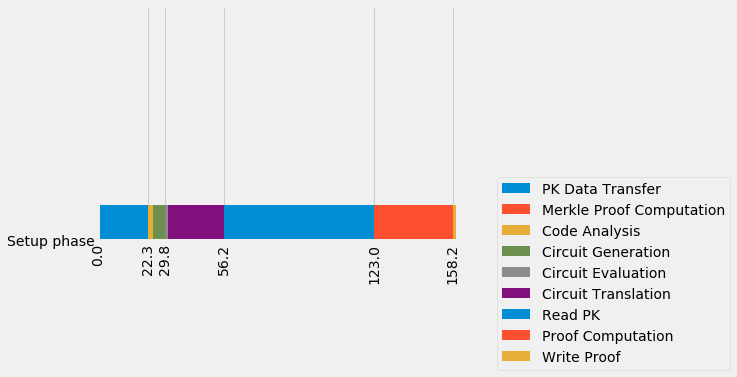

In [3]:
###PROVE###
###SETUP PLOT###
df2 = pandas.read_json("../Client/prove_"+circuit+"_output.json").round(5)
df2.columns = ['output', 'timestamp']
timestamps=df2['timestamp']
df2 = df2.iloc[:, [1,0]]
df2.set_index('timestamp')
#print(df2.to_string())
#print("___________________________________________________________")

df = pandas.read_json("../Client/prove_"+circuit+"_memory.json").round(5)
df.columns = ['memory', 'timestamp']
df = df.iloc[:, [1,0]]
df.set_index('timestamp')
#print(df.to_string())
#print(df.to_string())
#print(df2.to_string())
#print(df[:300].to_string())
df = df.merge(df2, how = 'outer')
df = df.sort_values('timestamp').reset_index(drop=True)
df['memory'] = df['memory'].fillna(value=0)
#print(df.to_string())

timestamps=df['timestamp']
highlights = [timestamps[0], timestamps[1], timestamps[3], timestamps[102], timestamps[114], timestamps[351], timestamps[385], timestamps[451], timestamps[546], timestamps[549]]
labels = ["PK Data Transfer", "Merkle Proof Computation", "Code Analysis", "Circuit Generation", "Circuit Evaluation", "Circuit Translation", "Read PK", "Proof Computation", "Write Proof"]

plt.figure()

#print(plt.style.available)
plt.style.use('fivethirtyeight')
plt.plot(df['timestamp'], df['memory'], linewidth=2, zorder=3, color='grey')

#print(df['timestamp'] in highlights)
#print(df[df['timestamp'] in highlights].to_string())

ticks=[]
for tick in highlights:
	if not ticks or ticks[-1]<tick-3:
		ticks.append(tick)
plt.xlabel("Execution time (s)")
plt.ylabel("Memory occupation (MB)")
print(type(numpy.arange(0, max(df['memory']), step=max(df['memory'])/5)))
plt.yticks(numpy.append(numpy.arange(0, max(df['memory']), step=max(df['memory'])/5), max(df['memory'])))
#plt.xticks(numpy.arange(0, max(df['timestamp']), step=max(df['timestamp'])/5))
plt.xticks(ticks, rotation = 45, fontsize=10)

for (i,instant) in enumerate(highlights[:-1]):
	index = df['timestamp'].between(highlights[i], highlights[i+1], inclusive="both")
	plt.fill_between(df['timestamp'][index], df['memory'][index], label=labels[i], alpha=0.8, zorder=4+i)
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5)).set_zorder(100)
plt.grid(linestyle = '--', linewidth = 2, zorder=20)
plt.axvspan(0, highlights[2], alpha=0.3, color='grey', zorder=1)
plt.axvspan(highlights[2], highlights[5], alpha=0.2, color='orange', zorder=1)
plt.axvspan(highlights[5], highlights[-1], alpha=0.2, color='teal', zorder=1)

plt.axvline(highlights[2], linewidth=1)
plt.axvline(highlights[5], linewidth=1)

plt.show()

plt.show()

for (i, instant) in enumerate(highlights[:-1]):
    plt.barh("Setup phase", highlights[i+1]-highlights[i], height=0.3, left = (highlights[i]), label=labels[i])
plt.legend(loc='upper right', bbox_to_anchor=(1.7, 0.3))
plt.xticks(ticks, rotation=90)
plt.ylim(0,1)
plt.show()

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


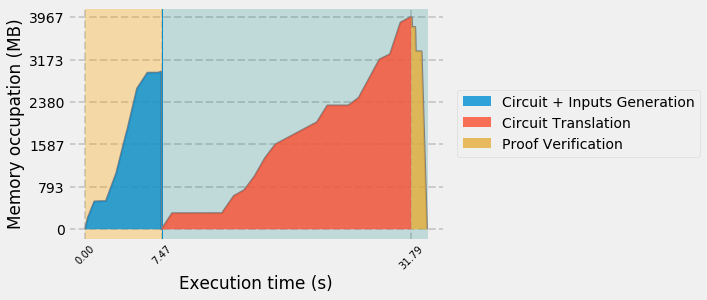

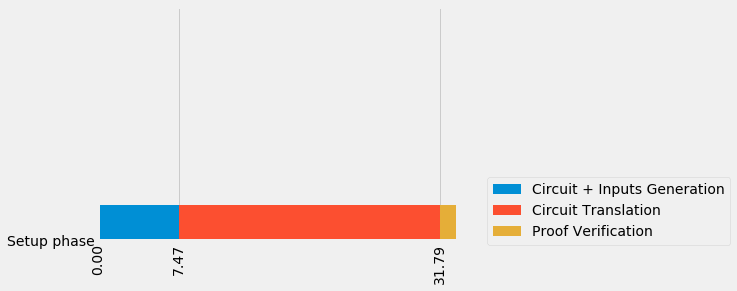

In [4]:
###PROVE###
###SETUP PLOT###
df2 = pandas.read_json("../Middlebox/verify_"+circuit+"_output.json").round(5)
df2.columns = ['output', 'timestamp']
timestamps=df2['timestamp']
df2 = df2.iloc[:, [1,0]]
df2.set_index('timestamp')
#print(df2.to_string())
#print("___________________________________________________________")

df = pandas.read_json("../Middlebox/verify_"+circuit+"_memory.json").round(5)
df.columns = ['memory', 'timestamp']
df = df.iloc[:, [1,0]]
df.set_index('timestamp')
#print(df.to_string())
#print(df.to_string())
#print(df2.to_string())
#print(df[:300].to_string())
df = df.merge(df2, how = 'outer')
df = df.sort_values('timestamp').reset_index(drop=True)
df['memory'] = df['memory'].fillna(value=0)
#print(df.to_string())

timestamps=df['timestamp']
highlights = [timestamps[0], timestamps[120], timestamps[156], timestamps[187]]#, timestamps[114], timestamps[351], timestamps[385], timestamps[451], timestamps[546], timestamps[549]]
labels = ["Circuit + Inputs Generation", "Circuit Translation", "Proof Verification"]

plt.figure()

#print(plt.style.available)
plt.style.use('fivethirtyeight')
plt.plot(df['timestamp'], df['memory'], linewidth=2, zorder=3, color='grey')

#print(df['timestamp'] in highlights)
#print(df[df['timestamp'] in highlights].to_string())

ticks=[]
for tick in highlights:
	if not ticks or ticks[-1]<tick-3:
		ticks.append(tick)
plt.xlabel("Execution time (s)")
plt.ylabel("Memory occupation (MB)")
plt.yticks(numpy.append(numpy.arange(0, max(df['memory']), step=max(df['memory'])/5), max(df['memory'])))
#plt.xticks(numpy.arange(0, max(df['timestamp']), step=max(df['timestamp'])/5))
plt.xticks(ticks, rotation = 45, fontsize=10)

for (i,instant) in enumerate(highlights[:-1]):
	index = df['timestamp'].between(highlights[i], highlights[i+1], inclusive="both")
	plt.fill_between(df['timestamp'][index], df['memory'][index], label=labels[i], alpha=0.8, zorder=4+i)
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5)).set_zorder(100)
plt.grid(linestyle = '--', linewidth = 2, zorder=20)
plt.axvspan(0, highlights[1], alpha=0.3, color='orange', zorder=1)
plt.axvspan(highlights[1], highlights[-1], alpha=0.2, color='teal', zorder=1)

plt.axvline(highlights[1], linewidth=1)
#plt.axvline(highlights[], linewidth=1)

plt.show()

plt.show()

for (i, instant) in enumerate(highlights[:-1]):
    plt.barh("Setup phase", highlights[i+1]-highlights[i], height=0.3, left = (highlights[i]), label=labels[i])
plt.legend(loc='upper right', bbox_to_anchor=(1.7, 0.3))
plt.xticks(ticks, rotation=90)
plt.ylim(0,1)
plt.show()

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

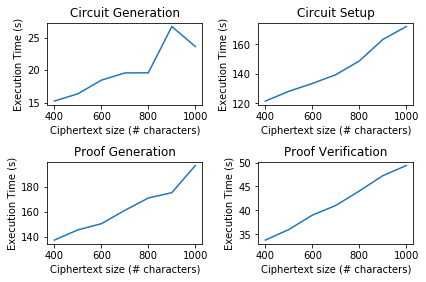

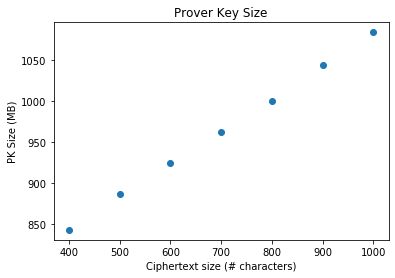

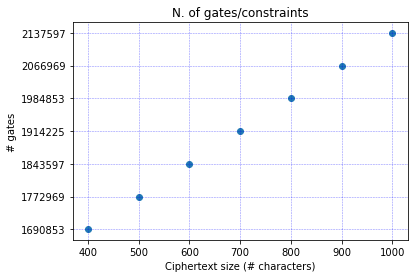

In [121]:
circuit='HTTP_String'
start=400
end=1100
fig_times, axs_time = plt.subplots(2, 2)

#fig_times = plt.figure()
ytitle_times = "Execution Time (s)"
xtitle = "Ciphertext size (# characters)"

num_gates=[]
times = pandas.DataFrame(columns = ['run', 'times'])
for i in range(start, end, 100):
    df = pandas.read_json("outputs/output_java_"+circuit+"_"+str(i)+"_1.json").round(5)
    df.columns = ['output', 'timestamp']
    num_gates += [df['output'].iloc[99].split()[-1]]
    times.loc[len(times)] = {'times': df['timestamp'].tail(1).values[0], 'run': i}
    #times = times.append({'times': df['timestamp'].tail(1).values[0], 'run': i}, ignore_index=True)

timestamps=df['timestamp']
df = df.iloc[:, [1,0]]
df.set_index('timestamp')

axs_time[0][0].plot(times['run'], times['times'])
axs_time[0][0].set_title('Circuit Generation')
axs_time[0][0].set_xlabel(xtitle)
axs_time[0][0].set_ylabel(ytitle_times)

#plt.show()
fig_time.suptitle("Time Complexity")


pksizes = []
times = pandas.DataFrame(columns = ['run', 'times'])
for i in range(start, end, 100):
    df = pandas.read_json("outputs/output_libsnark_setup_"+circuit+"_"+str(i)+"_1.json").round(5)
    df.columns = ['output', 'timestamp']
    pksizes+=[round(df['timestamp'].tail(2).values[0]/1000000, 2)]
    df = df[:-2]
    #print(df)
    times.loc[len(times)] = {'times': df['timestamp'].tail(1).values[0], 'run': i}

    
timestamps=df['timestamp']
df = df.iloc[:, [1,0]]
df.set_index('timestamp')

axs_time[0][1].plot(times['run'], times['times'])
axs_time[0][1].set_title('Circuit Setup')
axs_time[0][1].set_xlabel(xtitle)
axs_time[0][1].set_ylabel(ytitle_times)



times = pandas.DataFrame(columns = ['run', 'times'])
for i in range(start, end, 100):
    df = pandas.read_json("outputs/output_libsnark_prove_"+circuit+"_"+str(i)+"_1.json").round(5)
    df.columns = ['output', 'timestamp']
    #print(df)
    times.loc[len(times)] = {'times': df['timestamp'].tail(1).values[0], 'run': i}
    #times = times.append({'times': df['timestamp'].tail(1).values[0], 'run': i}, ignore_index=True)
#print(times)
timestamps=df['timestamp']
df = df.iloc[:, [1,0]]
df.set_index('timestamp')


axs_time[1][0].plot(times['run'], times['times'])
axs_time[1][0].set_title("Proof Generation")
axs_time[1][0].set_xlabel(xtitle)
axs_time[1][0].set_ylabel(ytitle_times)

times = pandas.DataFrame(columns = ['run', 'times'])
for i in range(start, end, 100):
    df = pandas.read_json("outputs/output_libsnark_verify_"+circuit+"_"+str(i)+"_1.json").round(5)
    df.columns = ['output', 'timestamp']
    #print(df)
    times.loc[len(times)] = {'times': df['timestamp'].tail(1).values[0], 'run': i}
    #times = times.append({'times': df['timestamp'].tail(1).values[0], 'run': i}, ignore_index=True)
#print(times)
timestamps=df['timestamp']
df = df.iloc[:, [1,0]]
df.set_index('timestamp')


axs_time[1][1].plot(times['run'], times['times'])
axs_time[1][1].set_title('Proof Verification')
axs_time[1][1].set_xlabel(xtitle)
axs_time[1][1].set_ylabel(ytitle_times)

fig_times.tight_layout(pad=1.0)

#fig_times.show()

fig_pksize, ax_pksize = plt.subplots()
ax_pksize.scatter(times['run'], pksizes)
ax_pksize.set_title("Prover Key Size")
ax_pksize.set_xlabel(xtitle)
ax_pksize.set_ylabel("PK Size (MB)")


#formatter = ticker.ScalarFormatter(useMathText=True)
#formatter.set_scientific(True) 
#formatter.set_powerlimits((0,0)) 
fig_ngates, ax_ngates = plt.subplots()
ax_ngates.scatter(times['run'], num_gates)
ax_ngates.set_title("N. of gates/constraints")
ax_ngates.set_xlabel(xtitle)
ax_ngates.set_ylabel("# gates")
ax_ngates.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
#yScalarFormatter = ScalarFormatterClass(useMathText=True)
#yScalarFormatter.set_powerlimits((0,0))
#ax_ngates.yaxis.set_major_formatter(yScalarFormatter)
plt.show()


